In [1]:
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import math

In [2]:

bn=gum.BayesNet('Coin and a Die')


bn.add(gum.LabelizedVariable('C','Coin', ['h', 't']))
bn.add(gum.LabelizedVariable('D','Die',  ['1','2','3','4','5','6']))

bn.addArc("C", "D")

def pyes(p_true): return [1-p_true, p_true]

bn.cpt("C").fillWith(pyes(0.5))

bn.cpt("D")[{'C':'h' }] = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]
bn.cpt("D")[{'C':'t' }] = [1/10, 1/10, 1/10, 1/10, 1/10, 5/10]


gnb.sideBySide(bn, *[bn.cpt(v) for v in bn.names()], valign='bottom', ncols=4,
               captions=["BN"]+[f"CPT({v})" for v in bn.names()])

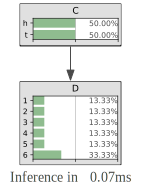

In [3]:
gnb.showInference(bn, evs={})

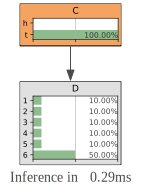

In [4]:
gnb.showInference(bn, evs={"C":'t'})

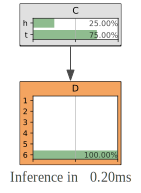

In [5]:
gnb.showInference(bn, evs={"D":'6'})

In [6]:
ie = gum.VariableElimination(bn)

def entropy(ie, target, natural=False):
    ie.eraseAllEvidence()
    ie.makeInference()
    potential = ie.posterior(target)
    if natural:
        entropy = - sum([ p * math.log(p)   for p in potential.tolist() ])
    else:
        entropy = - sum([ p * math.log2(p)   for p in potential.tolist() ])
    return entropy

entropy(ie, 'D')

2.4662478973127313

# Information gain


In [12]:
def value2probability(inf_method, var_name):
    var = inf_method.BN().variableFromName(var_name)
    inf_method.eraseAllEvidence()
    ie.makeInference()
    potential = inf_method.posterior(var_name)
    return dict(zip(var.labels(), potential.tolist()))

c2p = value2probability(ie, 'C')
print("C", c2p)

d2p = value2probability(ie, 'D')
print("D", d2p)



C {'h': 0.5, 't': 0.5}
D {'1': 0.13333333333333333, '2': 0.13333333333333333, '3': 0.13333333333333333, '4': 0.13333333333333333, '5': 0.13333333333333333, '6': 0.3333333333333333}


In [13]:
def entropy_for_evidence(ie, target, evidence, natural=False):
    ie.eraseAllEvidence()
    for k,v in evidence.items():
        ie.addEvidence(k, v)
    ie.makeInference()
    potential = ie.posterior(target)
    if natural:
        entropy = - sum([ p * math.log(p)   for p in potential.tolist() ])
    else:
        entropy = - sum([ p * math.log2(p)   for p in potential.tolist() ])
    return entropy

entropy_for_evidence(ie, 'D', {'C':'h'})


2.584962500721156

In [14]:
entropy_for_evidence(ie, 'D', {'C':'t'})


2.1609640474436813

In [15]:
def conditional_entropy(ie, target, evidence_varname, natural=False):
    v2p = value2probability(ie, evidence_varname)

    #print(f"P({evidence_varname}) = {v2p}")
    exp_ent = 0
    for k,v in v2p.items():
        he = entropy_for_evidence(ie, target, {evidence_varname:k}, natural=natural)
        #print(f"Compute entropy for P({target} | {evidence_varname}={k}) = {he}")
        exp_ent += v * he
    return exp_ent


conditional_entropy(ie, 'D', 'C')

2.3729632740824185

We can compare the conditional entropy to the (unconditioned) entropy of the variable:

In [17]:
entropy(ie, 'D')

2.4662478973127313

The difference between them is called *mutual information* or *information gain*:

In [18]:
entropy(ie, 'D') - conditional_entropy(ie, 'D', 'C')

0.09328462323031284